# Database Cracking Demo


```
 Copyright (C) 2017  LSBD Adaptive Databases Group
 
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

      http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

## Reference:

Idreos et. al. - Database Cracking - ICDE 2007

## CrackInTwo algorithm

Partitions the column range based on a threshold value

**Example:**

In [1]:
def crack_in_two(col, low, high, c):
    """
    Cracks a column partition into two subparitions.
     - returnr the position of the new partition point
    and the number of swaps.
    """
    i = low  # keeps track of the initial lower bound
    j = high - 1 # keeps track of the initial upper bound
    swaps = 0 # keeps track of the number of swaps performed
    
    while i < j:
        if col[i] < c:
            i += 1
        else:
            while col[j] >= c and j > i:
                j -= 1
            col[i], col[j] = col[j], col[i]
            swaps += 1
            i += 1
            j -= 1
    
    return (j, swaps)

In [2]:
import random

# Numbers from 0 to 19
column = list(range(20))
random.shuffle(column)
print(column)

# Crack and return the answer to the user
print(crack_in_two(column, 0, len(column), 8))
print(column)

[16, 19, 18, 4, 1, 17, 9, 7, 8, 10, 3, 2, 13, 15, 11, 12, 6, 14, 0, 5]
(7, 6)
[5, 0, 6, 4, 1, 2, 3, 7, 8, 10, 9, 17, 13, 15, 11, 12, 18, 14, 19, 16]


## CrackInThree algorithm

Partitions the column so that all values in the selected range end up
clustered together

**Example:**

In [3]:
def crack_in_three(col, low, high, c1, c2):
    """
    Cracks a column partition into three subparitions
    and return te positions of the new partition points
    """
    i = low  # keeps track of the initial lower bound
    j = high - 1 # keeps track of the initial upper bound
    swaps = 0 # keeps track of the number of swaps performed
    
    while col[j] >= c2 and j > i:
        j -= 1
        
    # from this point k is the lower bound
    # i is used as a supporting variable
    k = j
    
    while col[k] > c1 and k > i:
        if col[k] >= c2:
            col[j], col[k] = col[k], col[j]
            swaps += 1
            j -= 1
        k -= 1
    
    while i < k:
        if col[i] < c1:
            i += 1
        else:
            col[i], col[k] = col[k], col[i]
            swaps += 1
            while col[k] > c1 and k > i:
                if col[k] >= c2:
                    col[j], col[k] = col[k], col[j]
                    swaps += 1
                    j -= 1
                k -= 1
                
    return ((k, j), swaps)

In [4]:
import random

# Numbers from 0 to 19
column = list(range(20))
random.shuffle(column)
print(column)

# Crack and return the answer to the user
print(crack_in_three(column, 0, len(column), 8, 24))
print(column)

[8, 2, 19, 12, 18, 3, 4, 17, 11, 13, 5, 14, 0, 15, 10, 7, 9, 6, 16, 1]
((8, 19), 10)
[1, 2, 6, 7, 0, 3, 4, 5, 8, 13, 11, 14, 17, 15, 10, 18, 9, 12, 16, 19]


## Cracker SELECT

Each query looks for the lower and upper boundary in the cracker index
and then cracks the partitions in the middle, if they aren't already in the
smallest size.

In [5]:
def cracker_select(col, idx, low, high):
    """
    Looks up the response set in a cracker index and cracks the
    partitions that contain saisfying records
    """
    
    # In the first query we use CrackInThree to isolate the
    # the answers records
    if len(idx) == 0:
        res = crack_in_three(col, 0, len(col), low, high)
        idx._min = res[0][0]
        idx._max = res[0][1]
        idx.insert(low, res[0][0])
        idx.insert(high, res[0][1])
        return res
    
    # boundaries of the lowest partition than contains answer records
    p1_min = 0 if low < idx._min else idx.floor_item(low)[1]
    p1_max = len(col) if low > idx._max else idx.ceiling_item(low)[1]
    
    # crack the lowest partition to get the answer lower bound
    p1_res = crack_in_two(col, p1_min, p1_max, low)
    idx.insert(low, p1_res[0])
    if p1_res[0] < idx._min:
        idx._min = p1_res[0]
    
    # boundaries of the highest partition than contains answer records
    p2_min = 0 if high < idx._min else idx.floor_item(high)[1]
    p2_max = len(col) if high > idx._max else idx.ceiling_item(high)[1]
    
    # crack the highest partition to get the answer higher bound
    p2_res = crack_in_two(col, p2_min, p2_max, high)
    idx.insert(high, p2_res[0])
    if p2_res[0] < idx._max:
        idx._min = p1_res[0]
    
    # final answer boundaries and swap count
    return ((p1_res[0], p2_res[0]), p1_res[1] + p2_res[1])

## Experimental evaluation

Here we plot the response times and the number of swaps performed by
Database Cracking in a random workload

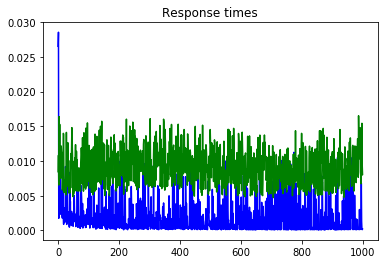

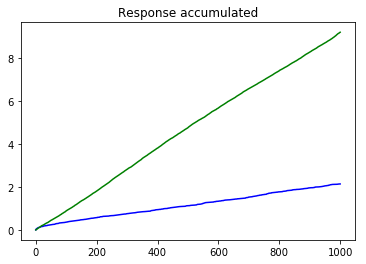

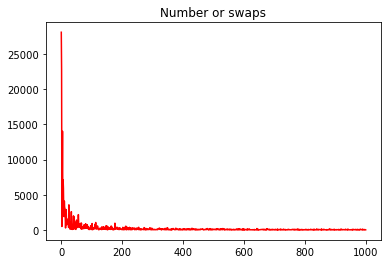

In [6]:
import random
import bintrees
import timeit
import matplotlib.pyplot as plt

# Cracker column
column_length = 100000
column = list(range(column_length))
random.shuffle(column)

# Cracker index that keeps track of the cracks positions
index = bintrees.AVLTree()

# Query execution times
linear_scan_times = []
cracking_times = []

linear_scan_times_sum = [0]
cracking_times_sum = [0]

# Number of swaps performed
swaps = []

# Put the query boundaries in context
low = -1
high = -1


# Performs a linear scan
def linear_scan():
    recs = 0
    for x in column:
        if x > low and x < high:
            recs += 1
    return recs

# Performs a range query with random bounds
def cracking_scan():
    swaps.append(cracker_select(column, index, low, high)[1])


# Run a number of range queries and collect the response times
for k in range(1000):
    low = random.randrange(0, column_length - 5)
    high = random.randrange(low + 1, column_length)
    linear_scan_times.append(timeit.timeit(linear_scan, number=1))
    cracking_times.append(timeit.timeit(cracking_scan, number=1))
    linear_scan_times_sum.append(linear_scan_times_sum[-1] + linear_scan_times[-1])
    cracking_times_sum.append(cracking_times_sum[-1] + cracking_times[-1])


# Plot the results on time ans swaps for the
# processed queries
plt.title('Response times')
plt.plot(cracking_times, 'b-')
plt.plot(linear_scan_times, 'g-')
plt.show()

plt.title('Response accumulated')
plt.plot(cracking_times_sum, 'b-')
plt.plot(linear_scan_times_sum, 'g-')
plt.show()

plt.title('Number or swaps')
plt.plot(swaps, 'r-')
plt.show()